In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from utils import load_quickdraw_data, show_image, get_available_folder_name, device
from model_classes import GPTConvolutionalNetwork as ModelClass
from torch import nn
from torch import optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
info = torch.load(f"models/95_classes_temp_model.pth")

model = ModelClass(info["num_classes"]).to(device)

model.load_state_dict(info["state_dict"])

FileNotFoundError: [Errno 2] No such file or directory: 'models/95_classes_temp_model.pth'

In [2]:
# Load the data
TRAIN_TEST_RATIO = 0.9
NUM_DRAWINGS = 50000 # None for all drawings
recognized = True

classes_file_name = "95_classes.txt"

num_classes, classes, combined_dataset_train, combined_dataset_test = load_quickdraw_data(classes_file_name, NUM_DRAWINGS, TRAIN_TEST_RATIO, recognized=recognized)

loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading ant drawings
load complete
loading apple drawings
load complete
loading arm drawings
load complete
loading axe drawings
load complete
loading backpack drawings
load complete
loading banana drawings
load complete
loading baseball drawings
load complete
loading baseball bat drawings
load complete
loading basket drawings
load complete
loading bed drawings
load complete
loading bee drawings
load complete
loading bicycle drawings
load complete
loading bird drawings
load complete
loading book drawings
load complete
loading bowtie drawings
load complete
loading brain drawings
load complete
loading bread drawings
load complete
loading broom drawings
load complete
loading bucket drawings
load complete
loading bus drawings
load complete
loading butterfly drawings
load complete
loading cactus drawings
load complete
loading cake drawings
load complete
loading calculat

In [7]:
# Create DataLoaders for batching
batch_size = 1000
combined_loader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_loader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

In [8]:
model = ModelClass(num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [10]:
os.makedirs("temp_models", exist_ok=True)
base_folder_name = f'{num_classes}_classes' if num_classes > 3 else '_'.join(classes)
folder_name = get_available_folder_name(base_folder_name + '_recognized' if recognized else '')
os.makedirs(f"temp_models/{folder_name}", exist_ok=True)

print_frequency = 100

for epoch in range(60):  # loop over the dataset multiple times
    for i, data in enumerate(combined_loader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % print_frequency == 0:    # print every [print_frequency] mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}')
        
    file_name = f"epoch_{epoch+1}_loss_{loss.item():.4f}"

    torch.save(
        {
            "model_class_name": model.__class__.__name__,
            "num_classes": num_classes,
            "state_dict": model.state_dict(),
        },
        f"temp_models/{folder_name}/{file_name}.pth",
    )
        
    scheduler.step()
print('Finished Training')

[1, 100] loss: 2.485
[1, 200] loss: 1.449
[1, 300] loss: 1.072
[1, 400] loss: 0.987
[1, 500] loss: 0.853
[1, 600] loss: 0.843
[1, 700] loss: 0.740
[1, 800] loss: 0.691
[1, 900] loss: 0.634
[1, 1000] loss: 0.602
[1, 1100] loss: 0.602
[1, 1200] loss: 0.570
[1, 1300] loss: 0.474
[1, 1400] loss: 0.565
[1, 1500] loss: 0.618
[1, 1600] loss: 0.504
[1, 1700] loss: 0.445
[1, 1800] loss: 0.558
[1, 1900] loss: 0.528
[1, 2000] loss: 0.591
[1, 2100] loss: 0.464
[1, 2200] loss: 0.398
[1, 2300] loss: 0.508
[1, 2400] loss: 0.481
[1, 2500] loss: 0.416
[1, 2600] loss: 0.468
[1, 2700] loss: 0.483
[1, 2800] loss: 0.484
[1, 2900] loss: 0.459
[1, 3000] loss: 0.393
[1, 3100] loss: 0.442
[1, 3200] loss: 0.389
[1, 3300] loss: 0.388
[1, 3400] loss: 0.392
[1, 3500] loss: 0.408
[1, 3600] loss: 0.409
[1, 3700] loss: 0.435
[1, 3800] loss: 0.418
[1, 3900] loss: 0.445
[1, 4000] loss: 0.396
[1, 4100] loss: 0.444
[1, 4200] loss: 0.440
[2, 100] loss: 0.349
[2, 200] loss: 0.367
[2, 300] loss: 0.391
[2, 400] loss: 0.399
[

KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0

y = []
y_predicted = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i, data in enumerate(combined_loader_test):
        if i % 10 == 0:  # Print every 10 batches (adjust as needed)
            print(f"Processing batch {i}/{len(combined_loader_test)}", end="\r")

        images, labels = data[0].to(device), data[1].to(device)
        logits = model(images)

        # Directly calculate the predicted classes without applying softmax
        predicted = torch.argmax(logits, dim=1)
        
        # Append to list (more efficient than np.append)
        y.extend(labels.cpu().numpy())
        y_predicted.extend(predicted.cpu().numpy())

        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = correct / total

# Convert lists to numpy arrays if further processing is needed
y = np.array(y)
y_predicted = np.array(y_predicted)

print("Model Accuracy:", accuracy)

Model Accuracy: 0.9025873684210526


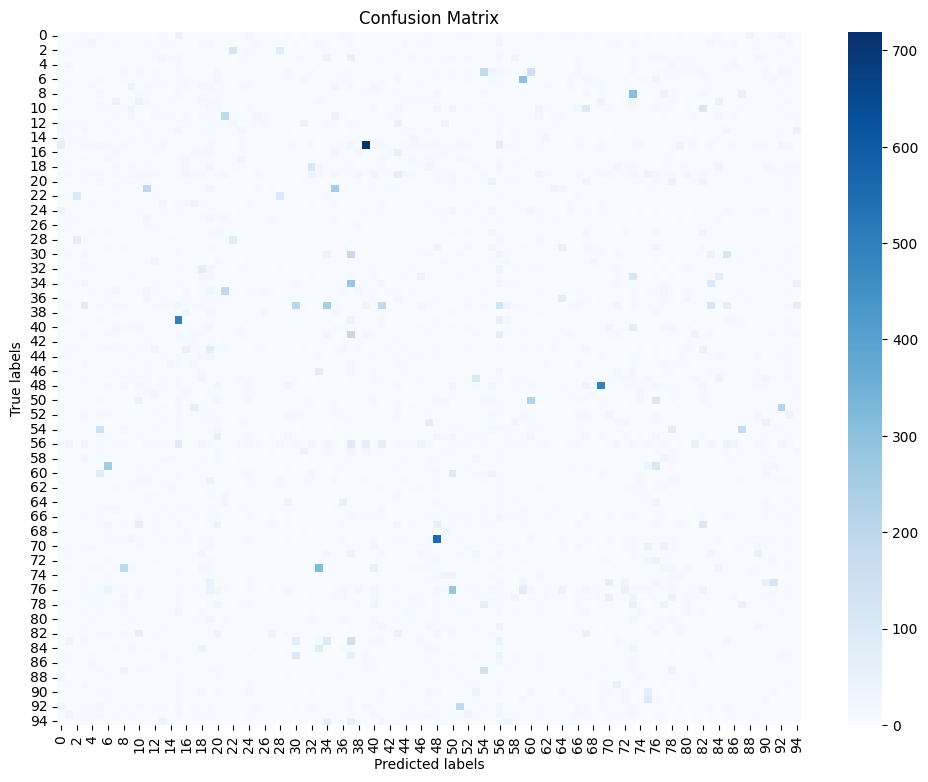

In [9]:
model_confusion_matrix = confusion_matrix(y, y_predicted)

np.fill_diagonal(model_confusion_matrix, 0)

plt.figure(figsize=(12, 9))
sns.heatmap(model_confusion_matrix, annot=False, cmap='Blues', linecolor=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Find the highest values and their indices
n_highest = 5  # Number of highest values to show
flat_indices = np.argsort(model_confusion_matrix.ravel())[-n_highest:]
row_indices, col_indices = np.unravel_index(flat_indices, model_confusion_matrix.shape)

print(f"Highest confusion:")
for i in range(n_highest - 1, -1, -1):  # Print in descending order
    value = model_confusion_matrix[row_indices[i], col_indices[i]] / total
    print(f"Value: {value}, Index: ({row_indices[i]}, {col_indices[i]}), Classes: ({classes[row_indices[i]]}, {classes[col_indices[i]]})")

Highest confusion:
Value: 0.0015233760895634967, Index: (15, 39), Classes: (bird, duck)
Value: 0.0011759022666310718, Index: (69, 48), Classes: (leaf, feather)
Value: 0.0010424214687972744, Index: (39, 15), Classes: (duck, bird)
Value: 0.001038183983151757, Index: (48, 69), Classes: (feather, leaf)
Value: 0.0006674039891689866, Index: (73, 33), Classes: (moon, cookie)


Predicted: tensor([51], device='mps:0') fish
Actual: tensor(51, device='mps:0') fish


Python(77406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


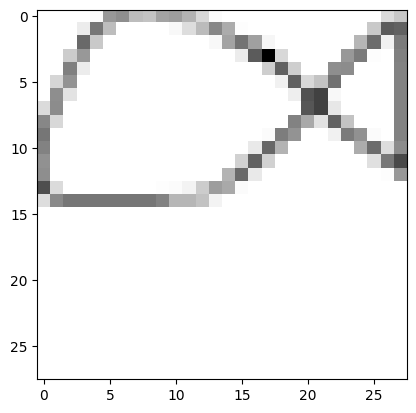

Predicted: tensor([10], device='mps:0') baseball bat
Actual: tensor(10, device='mps:0') baseball bat


Python(77412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


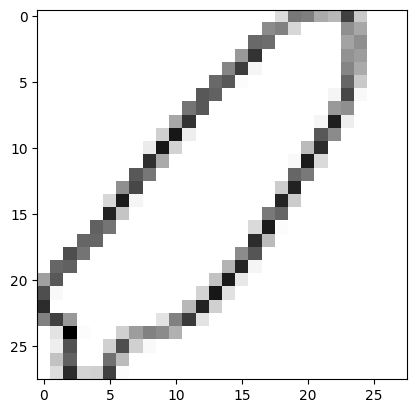

Predicted: tensor([60], device='mps:0') hand
Actual: tensor(60, device='mps:0') hand


Python(77415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


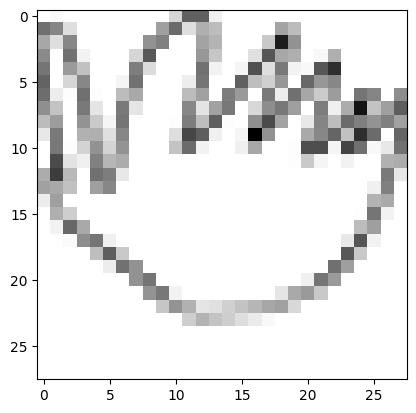

Predicted: tensor([66], device='mps:0') key
Actual: tensor(66, device='mps:0') key


Python(77420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


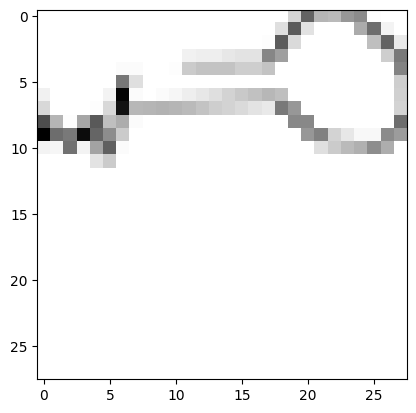

Predicted: tensor([32], device='mps:0') cloud
Actual: tensor(32, device='mps:0') cloud


Python(77447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77448) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


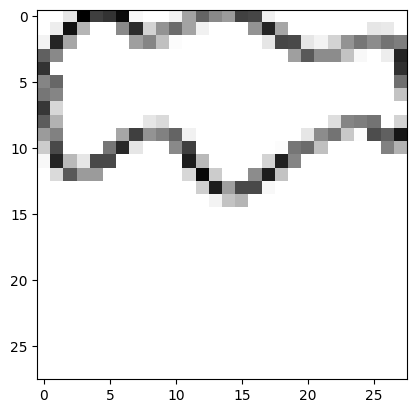

Predicted: tensor([37], device='mps:0') dog
Actual: tensor(58, device='mps:0') grapes


Python(77460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


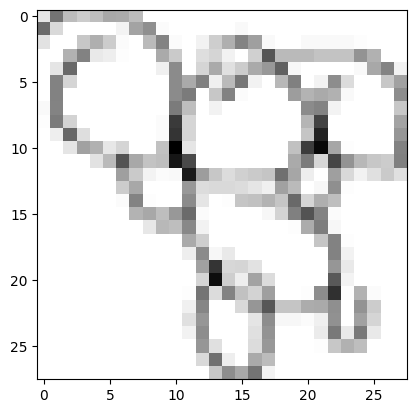

In [11]:
with torch.no_grad():  # Disable gradient calculation for inference
    for i, data in enumerate(combined_loader_test):
        images, labels = data[0].to(device), data[1].to(device)
        image = images[0]
        label = labels[0]

        predicted = torch.argmax(model(image.unsqueeze(0)), dim=1)
        print("Predicted:", predicted, classes[predicted])
        print("Actual:", label, classes[label])

        show_image(image.cpu())

        if i > 4:
            break

In [9]:
os.makedirs("models", exist_ok=True)

file_name = f"{f'{num_classes}_classes' if num_classes > 3 else '_'.join(classes)}_{accuracy:.4f}_acc"

torch.save(
    {
        "model_class_name": model.__class__.__name__,
        "num_classes": num_classes,
        "state_dict": model.state_dict(),
    },
    f"models/{file_name}.pth",
)